In [1]:
import numpy as np
from pathlib import Path
import tensorflow as tf
from keras.layers import Input, RandomFlip, RandomContrast, BatchNormalization, RandomTranslation, Flatten, Dropout
from keras.layers import Dense, Conv2D, Activation, MaxPooling2D, GlobalMaxPooling2D, Rescaling
import matplotlib.pyplot as plt
from PIL import Image

# Download Dataset
---

In [3]:

import os
import subprocess
import zipfile

DS_DESTINATION="media/TP1-3-natural-scenes.zip"
DS_UNZIP_DEST=DS_DESTINATION.replace(".zip","")
DS_DRIVE_ID="1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ"
TRAIN_DIRECTORY = Path("media/TP1-3-natural-scenes/seg_train/seg_train/")
TEST_DIRECTORY = Path("media/TP1-3-natural-scenes/seg_test/seg_test/")

if not os.path.isfile(DS_DESTINATION):
    print(subprocess.run(["gdown", DS_DRIVE_ID, "-O", DS_DESTINATION], 
                        capture_output=True))
    with zipfile.ZipFile(DS_DESTINATION, 'r') as zip_ref:
        zip_ref.extractall(DS_UNZIP_DEST)
    
    for DIR in [TRAIN_DIRECTORY,TEST_DIRECTORY ] :
        path, directories, files = [ (p, d, f) for p,d,f in os.walk(DIR)][0]
        root_path = str(path)
        labels = directories

        for label in labels:
            current_dir = os.path.join(root_path, label)
            print(f"Working on dir {label} on {path}")
            for path, directories, image_files in os.walk(str(current_dir)):
                for image_file in image_files:
                    current_name = os.path.join(current_dir, image_file)
                    new_name = os.path.join(current_dir, label + "_" + image_file)
                    os.rename(current_name, new_name)

In [4]:
BATCH_SIZE = 150
# Tamaño de las imágenes
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIRECTORY,
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE
    )

val_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIRECTORY,
    validation_split=0.2,
    subset="validation",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE
    )

# Obtiene los nombres de las clases
class_names = train_ds.class_names
num_classes = len(class_names)
class_lens = {}
val_lens = {}


for c in class_names:
    train_dir = TRAIN_DIRECTORY.joinpath(c)
    val_dir = TEST_DIRECTORY.joinpath(c)
    class_lens[c] = len([name for name in os.listdir(train_dir)])
    val_lens[c] = len([name for name in os.listdir(val_dir)])

print(f"Train: {class_lens}")
print(f"Test:{val_lens}")



Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 3000 files belonging to 6 classes.
Using 600 files for validation.
Train: {'buildings': 2191, 'forest': 2271, 'glacier': 2404, 'mountain': 2512, 'sea': 2274, 'street': 2382}
Test:{'buildings': 437, 'forest': 474, 'glacier': 553, 'mountain': 525, 'sea': 510, 'street': 501}


tf.Tensor([0. 0. 0. 0. 0. 1.], shape=(6,), dtype=float32) 5
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
tf.Tensor([0. 1. 0. 0. 0. 0.], shape=(6,), dtype=float32) 1
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
tf.Tensor([0. 0. 1. 0. 0. 0.], shape=(6,), dtype=float32) 2
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
tf.Tensor([0. 1. 0. 0. 0. 0.], shape=(6,), dtype=float32) 1
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
tf.Tensor([0. 0. 1. 0. 0. 0.], shape=(6,), dtype=float32) 2
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
tf.Tensor([0. 0. 1. 0. 0. 0.], shape=(6,), dtype=float32) 2
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
tf.Tensor([0. 0. 0. 0. 1. 0.], shape=(6,), dtype=float32) 4
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
tf.Tensor([0. 0. 0. 0. 0. 1.], shape=(6,), dtype=float32) 5
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
tf.Tenso

<Figure size 1000x1000 with 0 Axes>

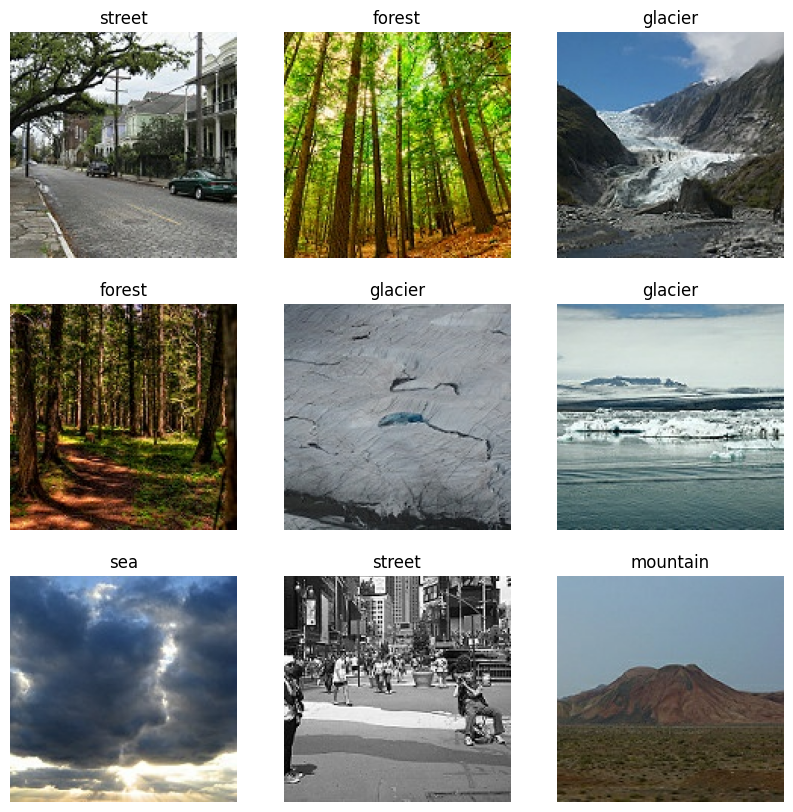

In [5]:
plt.figure(figsize=(10, 10))

for images, labels in val_ds.take(1):
  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    print(labels[i], list(labels[i]).index(1))
    print(class_names)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)

    plt.title(class_names[class_idx])
    plt.axis("off")

In [6]:
def build_model(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(8, (3, 3))(x)
    x = Activation("relu")(x)

    x = Conv2D(16, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(output_labels)(x)
    x = Activation("softmax")(x)
    return tf.keras.Model(inputs=[i], outputs=[x])

In [7]:
print("Building model")
model = build_model((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model


In [8]:
EPOCHS = 30
# Entrena el modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 314ms/step - accuracy: 0.3462 - loss: 1.5345 - val_accuracy: 0.5233 - val_loss: 1.1960
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 304ms/step - accuracy: 0.5635 - loss: 1.1148 - val_accuracy: 0.5617 - val_loss: 1.0352
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 313ms/step - accuracy: 0.6143 - loss: 0.9974 - val_accuracy: 0.6933 - val_loss: 0.8724
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 338ms/step - accuracy: 0.6592 - loss: 0.9065 - val_accuracy: 0.6867 - val_loss: 0.8267
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 313ms/step - accuracy: 0.6863 - loss: 0.8334 - val_accuracy: 0.7117 - val_loss: 0.8035
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 311ms/step - accuracy: 0.6799 - loss: 0.8403 - val_accuracy: 0.7450 - val_loss: 0.7115
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 309ms/step - accuracy: 0.7193 - loss: 0.7599 - val_accuracy: 0.6883 - val_loss: 0.7863
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 299ms/step - accuracy: 0.7296 - loss: 0.7395 - val_accu

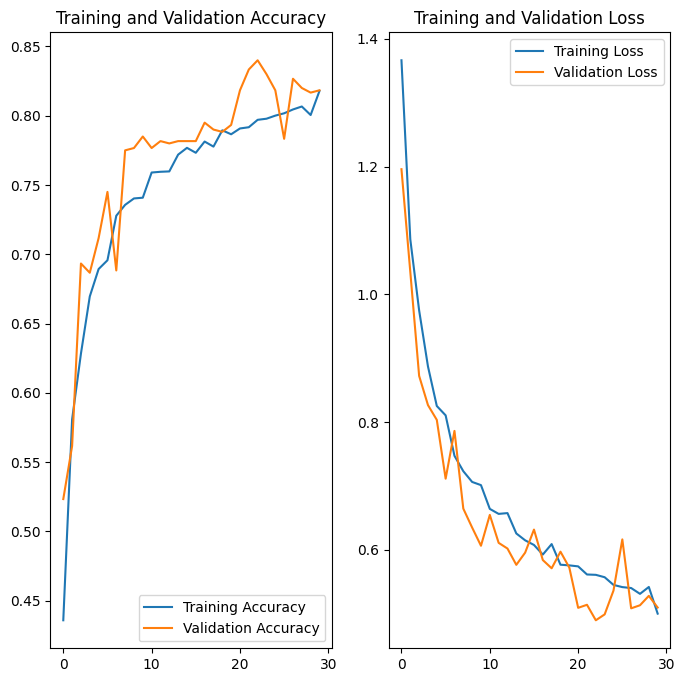

In [9]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
[[0.33122742 0.1759455  0.00402716 0.00463676 0.00416386 0.47999924]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[0.01116044 0.00515862 0.15259963 0.260703   0.56505674 0.00532164]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[[8.2561857e-01 1.9533826e-04 3.4905995e-08 3.4627021e-08 2.3013078e-07
  1.7418593e-01]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[0.00750653 0.01192708 0.53088176 0.39408687 0.01266971 0.04292801]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[0.06714478 0.0677997  0.04807425 0.7197677  0.06488299 0.03233058]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[[1.8382310e-03 9.8531973e-01 2.6974891e-04 1.2037779e-02 2.6651646e-04
  2.6808091e-04]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[[6.9975737e-05 6.6975813e-06 8.7751420e-03 3.6531099e-04 9.9069083e-01
  9.2003756e-05]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[4.2658434e-03 5.6623787e-05 9.6701080e-01 7.6134298e-03 2.8997599e-03
  1.8153524e-02]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[0.00802706 0.001

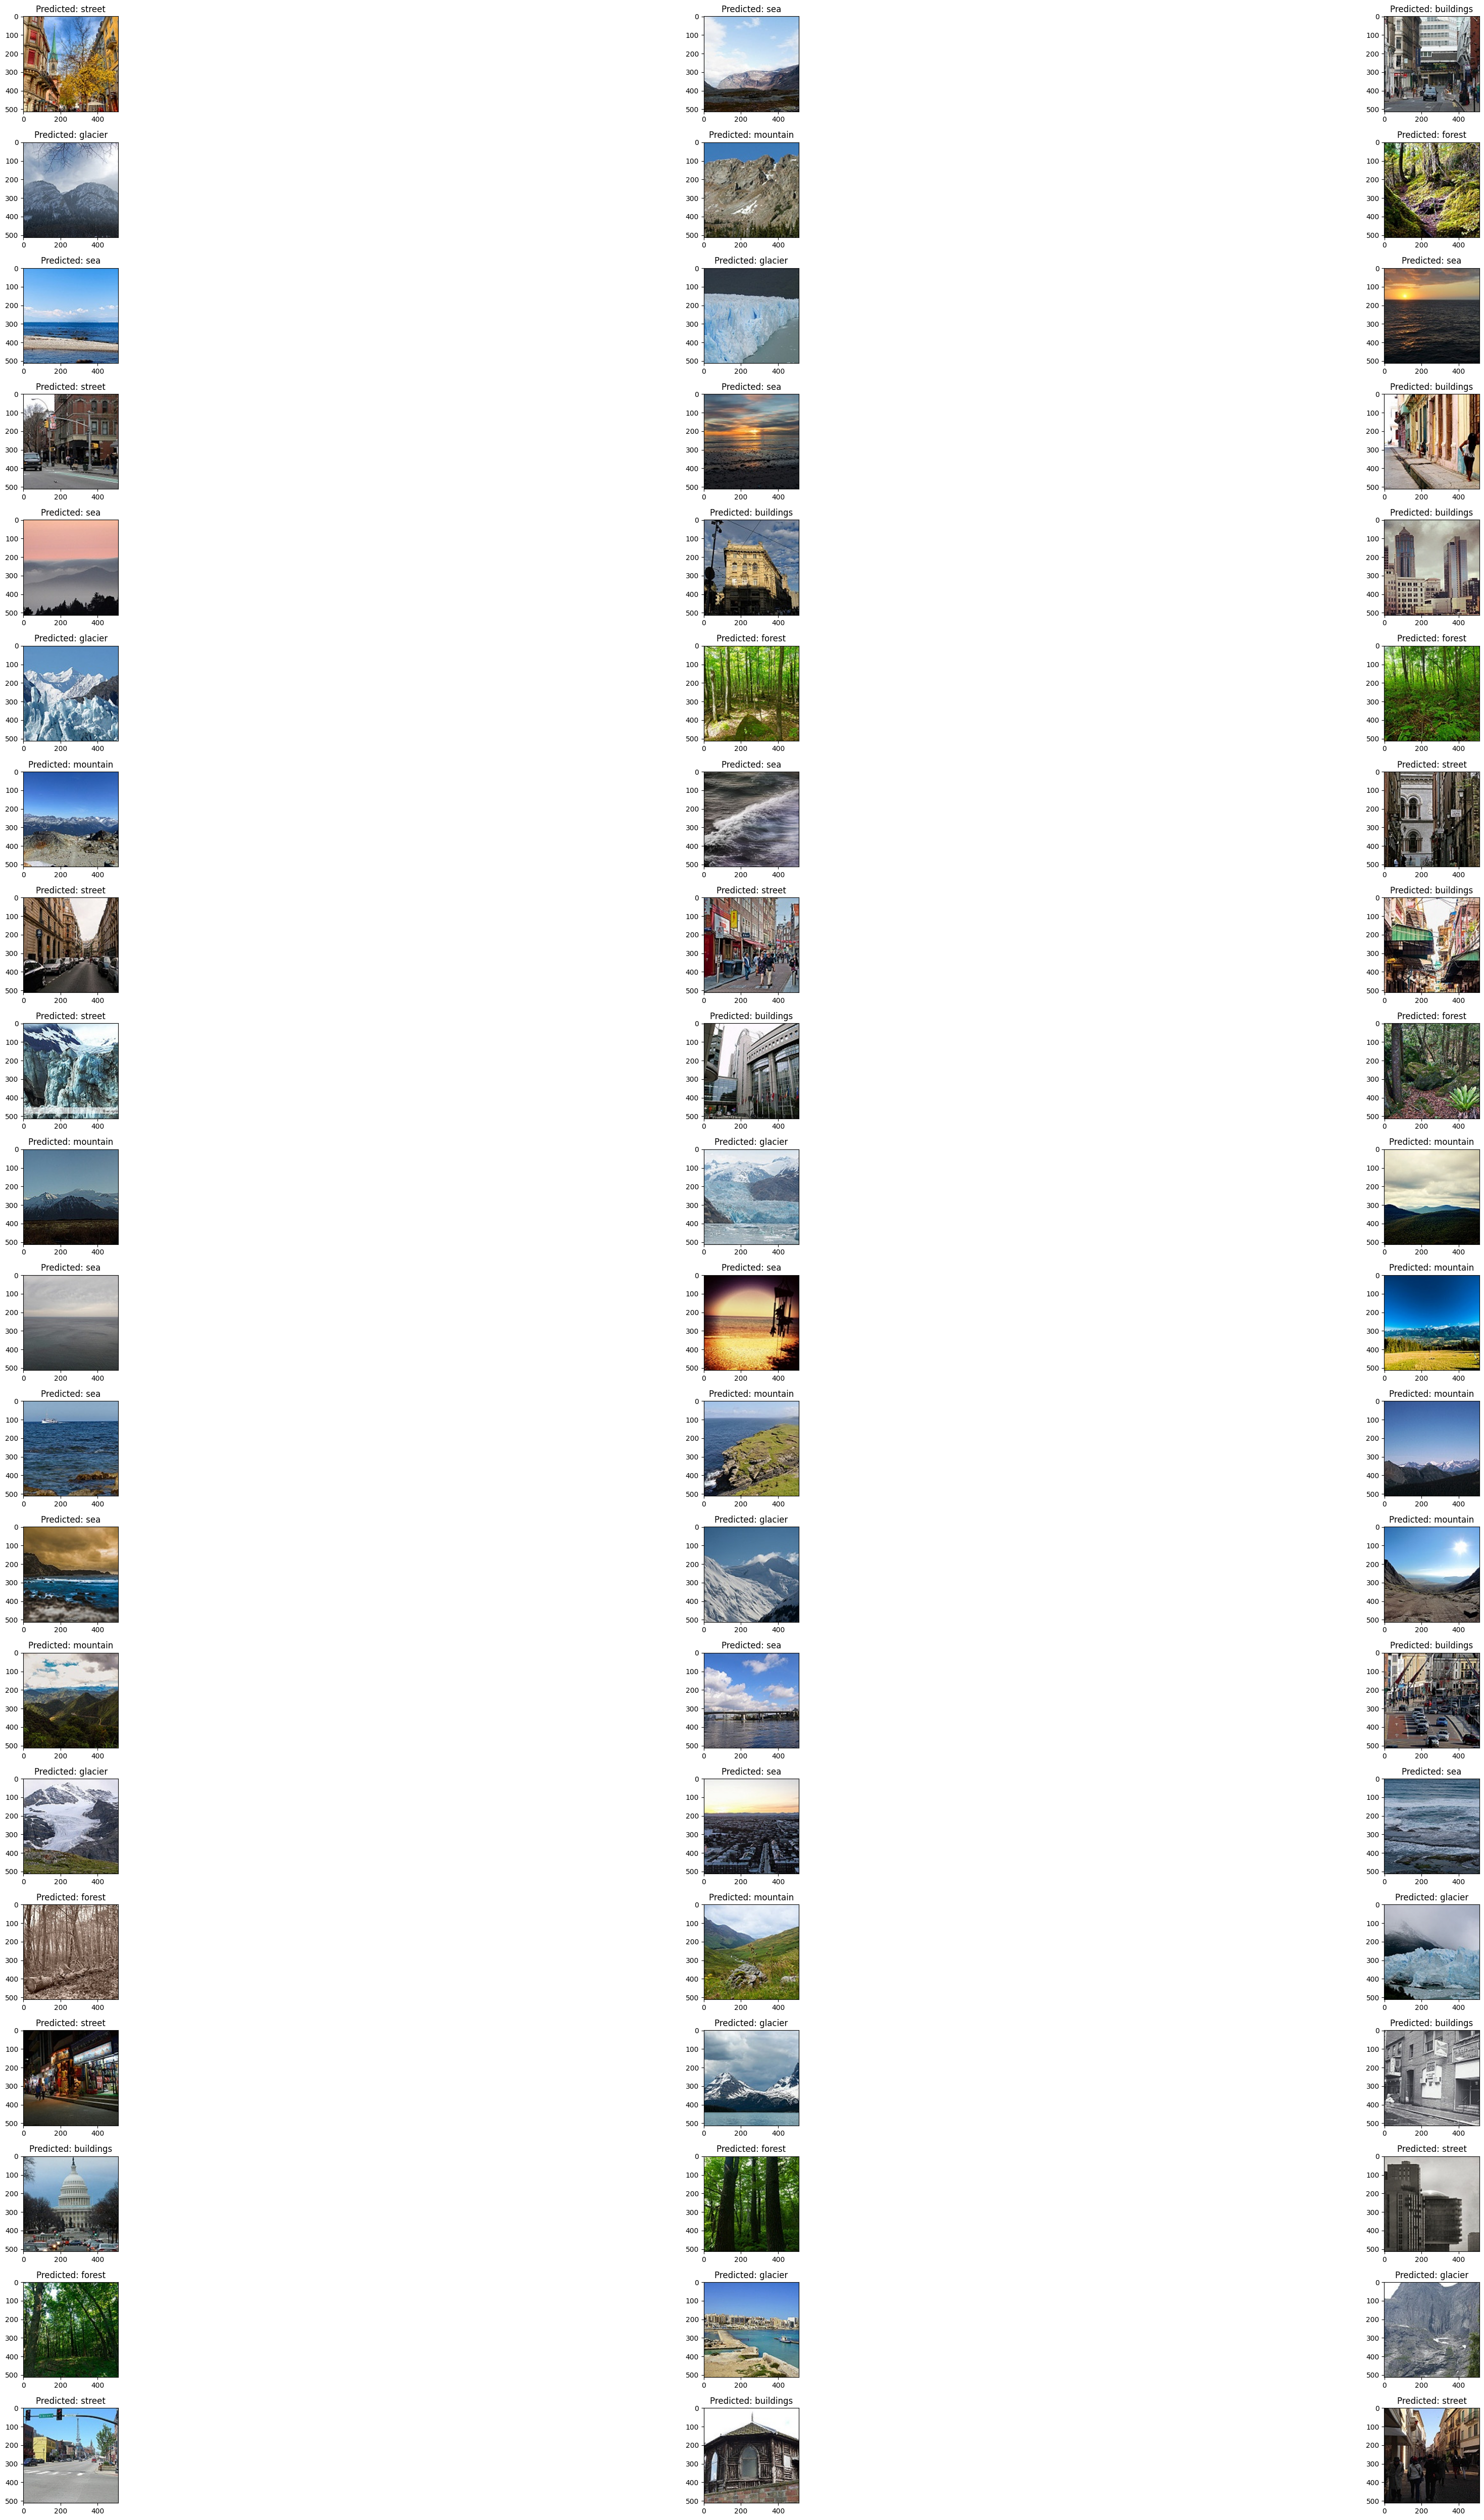

In [10]:
# Function to preprocess the image
def preprocess_image(image_path, target_size=(150, 150)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    return img

# Test images directory
TEST_IMAGES_DIRECTORY = Path("media/TP1-3-natural-scenes/seg_pred/seg_pred/")

# Get list of test image paths
test_image_paths = list(TEST_IMAGES_DIRECTORY.glob("*.jpg"))

# Display 5 images with their actual and predicted classes
sx=20
sy=3
fig, axs = plt.subplots(sx, sy, figsize=(50, 50))

i = 0
for x in range(0, sx):
    for y in range(0,sy):

        image_path = test_image_paths[i]
        image = preprocess_image(image_path)
        image_show = preprocess_image(image_path,(512,512))
        axs[x][y].imshow(image_show)
        image = np.expand_dims(image, axis=0)  # Add batch dimension

        # Perform prediction
        prediction = model.predict(image)
        print(prediction)
        predicted_class_index = np.argmax(prediction)
        predicted_class = class_names[predicted_class_index]        

        axs[x][y].set_title(f"Predicted: {predicted_class}")
        i+=1

plt.tight_layout()
plt.show()